In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from scipy import special
from tensorflow.keras import layers
np.random.seed(1)
tf.random.set_seed(1)
from math import erfc

In [2]:
M = 16
k = int(np.log2(M))
n = 1
np.random.seed(40)
dec_loss = keras.losses.SparseCategoricalCrossentropy()
mean_loss = keras.metrics.Mean()

In [3]:
def get_noise_dev(ebno):
    # ebno in dB
    lin_ebno = 10**(ebno/10)
    noise_dev = 1/np.sqrt(2*k*lin_ebno)
    return noise_dev

In [4]:
class MI_estimator(tf.keras.Model):
    """Takes model specifications as input and returns score"""
    ## x has shape batch_size*2n ## 
    ## diagonal of 'scores' is joint score while off-diagonal is marginal ##
    def __init__(self, nodes, num_layers, activation):
        super(MI_estimator, self).__init__()
        self.func = tf.keras.Sequential(
          [tf.keras.layers.Dense(nodes, activation) for _ in range(num_layers)] + [tf.keras.layers.Dense(1)])
    def call(self, x, y): 
        batch_size = x.shape[0]
        x_rep = tf.tile(x, (batch_size, 1))
        y_rep = tf.repeat(y, batch_size, axis=0)
        xy_pairs = tf.concat((x_rep, y_rep), axis=1)
        scores = self.func(xy_pairs)
        return tf.reshape(scores, (batch_size, batch_size))

In [5]:
def MINE(scores):
    batch_size = scores.shape[0]
    joint = tf.reduce_mean(tf.linalg.diag_part(scores))
    marg = tf.math.reduce_sum(tf.math.exp(scores)) - tf.math.reduce_sum(tf.math.exp(tf.linalg.diag_part(scores)))
    marg = tf.math.log(marg/((batch_size-1)*batch_size))
    ##taking average using only off-diagonal elements
    return joint-marg

In [6]:
def random_sample(batch_size):
    '''return random integers in range M with shape (batch_size,1)'''
    # odd_one = np.random.randint(M)
    # msg_list = np.arange(M)
    # repeat_times = [batch_size//M]*M
    # repeat_times[odd_one] = batch_size - (M-1)*(batch_size//M)
    # msg = np.repeat(msg_list,repeat_times)
    # assert len(msg) == batch_size
    msg = np.random.randint(M, size=(batch_size,1))
    return msg

def test_encoding(M=16, n=1):
    inp = np.arange(0,M)
    coding = encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [7]:
def train_mi(MI_estimator, n_epochs, n_steps, batch_size, learning_rate):
    optimizer_mi = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        loss_sum = 0
        for step in range(1, n_steps + 1):
            X_batch = random_sample(batch_size)
            with tf.GradientTape() as tape:
                x_enc = encoder(X_batch, training=True)
                y_rec = channel(x_enc)
                score = MI_estimator(x_enc,y_rec)
                loss = -MINE(score)
                gradients = tape.gradient(loss, MI_estimator.trainable_variables) 
                optimizer_mi.apply_gradients(zip(gradients, MI_estimator.trainable_variables))
            loss_sum = loss_sum-loss
        mi_loss = loss_sum/n_steps
        if(epoch%n_epochs==0):
            print(f'Epoch: {epoch}, Mi : {mi_loss:.3f}')

In [8]:
def train_enc(MI_estimator, n_epochs, n_steps, batch_size, learning_rate):
    optimizer_enc = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        loss_sum = 0
        for step in range(1, n_steps + 1):
            X_batch  = random_sample(batch_size)
            with tf.GradientTape() as tape:
                x_enc = encoder(X_batch, training=True)
                y_rec = channel(x_enc)
                score = MI_estimator(x_enc, y_rec)
                loss = -MINE(score)
                gradients = tape.gradient(loss, encoder.trainable_variables) 
                optimizer_enc.apply_gradients(zip(gradients, encoder.trainable_variables))
            loss_sum = loss_sum-loss
        enc_loss = loss_sum/n_steps
        if(epoch%n_epochs==0):
            print(f'Epoch: {epoch}, Enc loss : {enc_loss:.3f}')
            test_encoding(M, 1)

In [9]:
def train_dec(autoencoder,n_epochs=1, n_steps=5, batch_size=512, learning_rate=5e-3):
    optimizer_dec = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1,n_epochs+1):
        running_loss = 0.
        symbol_err = 0.
        for step in range(n_steps):
            X_batch = random_sample(batch_size)
            # X_batch dim : (batch_size,1)
            with tf.GradientTape() as tape:
                probs = autoencoder(X_batch, training=True)
                # probs dim : (batch_size,M)
                loss = tf.reduce_mean(dec_loss(X_batch,probs))
                # loss dim : (1)
                gradients = tape.gradient(loss,decoder.trainable_variables)
                optimizer_dec.apply_gradients(zip(gradients,decoder.trainable_variables))
            running_loss += loss
            symbol_err += symbol_error(X_batch,probs)
        running_loss = running_loss/n_steps
        symbol_err = symbol_err/n_steps
        if(epoch%n_epochs==0):
            print(f'epoch : {epoch} ; dec loss : {running_loss:.3f} ; symbol error : {symbol_err:.3f}')

In [10]:
def symbol_error(input_msg, msg):
    batch_size = input_msg.shape[0]
    decoded_msg = np.argmax(msg, 1)
    pred_error = np.not_equal(np.reshape(input_msg, (-1,batch_size)), decoded_msg) 
    bber = np.mean(pred_error.astype(np.float32))
    return bber

In [11]:
x = np.array([0,1,2])
x=x.T
y = np.array([[0.6, 0.2, 0.2], [0.1, 0.8, 0.1], [0.5, 0.2, 0.3]])
print(symbol_error(x,y))

0.33333334


In [12]:
SNR = 7
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
channel_layer = keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=get_noise_dev(SNR)))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,M])) ##not the same shape layer as given in the original code. Only used to reduce dimension of the output of the embedding layer

score_fn = MI_estimator(256, 2, 'relu')

## relu activation didn't produce good results
encoder = keras.models.Sequential([keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal', input_length=1), 
                                   shape_layer, keras.layers.Dense(M, activation="elu"), 
                                   #keras.layers.Dense(M, activation="relu"), 
                                   keras.layers.Dense(2*n, activation=None), 
                                   norm_layer])
channel = keras.models.Sequential([channel_layer])
decoder = keras.models.Sequential([
                                   keras.layers.Input(shape=(2*n)),
                                   keras.layers.Dense(M,activation='elu'),
                                #    keras.layers.Dense(M,activation='relu'),
                                   keras.layers.Dense(M,activation='softmax')
])
autoencoder = keras.models.Sequential([encoder,channel,decoder])
autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 2)                 562       
_________________________________________________________________
sequential_2 (Sequential)    (None, 2)                 0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 16)                320       
Total params: 882
Trainable params: 882
Non-trainable params: 0
_________________________________________________________________


Encoder Training Iter 1/10
Epoch: 5, Mi : 2.125
Epoch: 5, Enc loss : 2.427


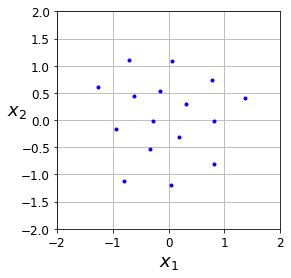

----------------------------------------------------------------------------------------------------
Encoder Training Iter 2/10
Epoch: 5, Mi : 2.531
Epoch: 5, Enc loss : 2.579


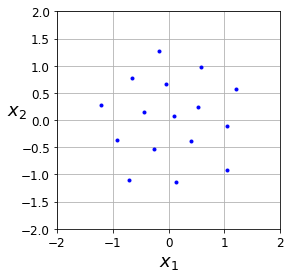

----------------------------------------------------------------------------------------------------
Encoder Training Iter 3/10
Epoch: 5, Mi : 2.642
Epoch: 5, Enc loss : 2.555


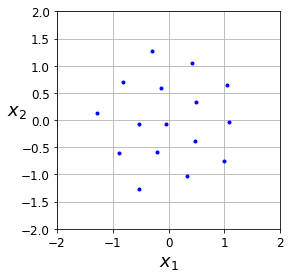

----------------------------------------------------------------------------------------------------
Encoder Training Iter 4/10
Epoch: 5, Mi : 2.564
Epoch: 5, Enc loss : 2.585


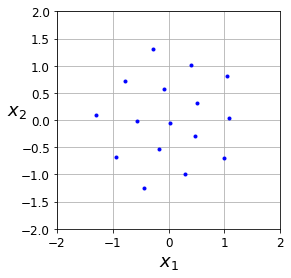

----------------------------------------------------------------------------------------------------
Encoder Training Iter 5/10
Epoch: 5, Mi : 2.554
Epoch: 5, Enc loss : 2.608


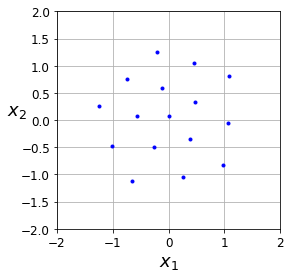

----------------------------------------------------------------------------------------------------
Encoder Training Iter 6/10
Epoch: 5, Mi : 2.608
Epoch: 5, Enc loss : 2.584


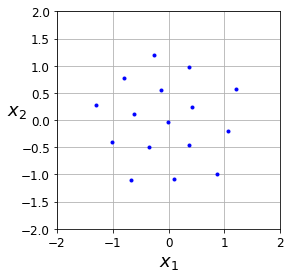

----------------------------------------------------------------------------------------------------
Encoder Training Iter 7/10
Epoch: 5, Mi : 2.605
Epoch: 5, Enc loss : 2.571


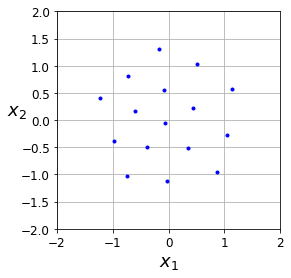

----------------------------------------------------------------------------------------------------
Encoder Training Iter 8/10
Epoch: 5, Mi : 2.636
Epoch: 5, Enc loss : 2.561


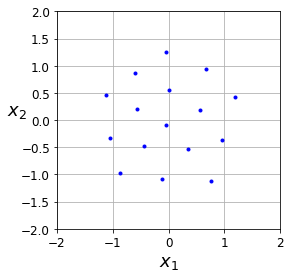

----------------------------------------------------------------------------------------------------
Encoder Training Iter 9/10
Epoch: 5, Mi : 2.586
Epoch: 5, Enc loss : 2.615


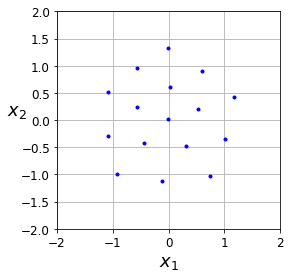

----------------------------------------------------------------------------------------------------
Encoder Training Iter 10/10
Epoch: 5, Mi : 2.558
Epoch: 5, Enc loss : 2.616


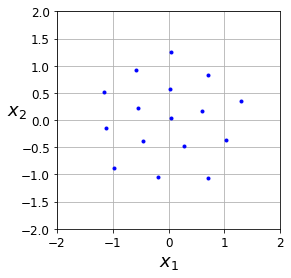

----------------------------------------------------------------------------------------------------
Decoder Training Iter 1/10
epoch : 1 ; dec loss : 0.796 ; symbol error : 0.174
Decoder Training Iter 2/10
epoch : 1 ; dec loss : 0.185 ; symbol error : 0.059
Decoder Training Iter 3/10
epoch : 1 ; dec loss : 0.164 ; symbol error : 0.058
Decoder Training Iter 4/10
epoch : 1 ; dec loss : 0.161 ; symbol error : 0.058
Decoder Training Iter 5/10
epoch : 1 ; dec loss : 0.160 ; symbol error : 0.057
Decoder Training Iter 6/10
epoch : 1 ; dec loss : 0.159 ; symbol error : 0.058
Decoder Training Iter 7/10
epoch : 1 ; dec loss : 0.163 ; symbol error : 0.059
Decoder Training Iter 8/10
epoch : 1 ; dec loss : 0.160 ; symbol error : 0.058
Decoder Training Iter 9/10
epoch : 1 ; dec loss : 0.162 ; symbol error : 0.058
Decoder Training Iter 10/10
epoch : 1 ; dec loss : 0.160 ; symbol error : 0.058


In [13]:
np.random.seed(40)
lr = 5e-3
tot_steps = 10
for iter in range(tot_steps):
    print("Encoder Training Iter {}/{}".format(iter+1, tot_steps))
    train_mi(score_fn, n_epochs=5, n_steps=20, batch_size=64, learning_rate=lr)
    train_enc(score_fn, n_epochs=5, n_steps=40, batch_size=64, learning_rate=lr)
    print('-'*100)
dec_lr = lr
dec_steps = 10
for iter in range(dec_steps):
    print("Decoder Training Iter {}/{}".format(iter+1, dec_steps))
    train_dec(autoencoder,n_epochs=1,n_steps=500,batch_size=512,learning_rate=lr)

In [15]:
def noise_perf():
    snr_range = np.linspace(0, 14, 30)
    bber_vec = [None] * len(snr_range)
    qam_err = [None]*len(snr_range)
    batch_size=1024
    iters = 100
    for snr in range(len(snr_range)):
        running_err = 0.
        for it in range(iters):
            noise_std = get_noise_dev(snr_range[snr])
            X_batch  = random_sample(batch_size)
            enc_out = encoder(X_batch, training=False)
            dec_in = enc_out + tf.random.normal(tf.shape(enc_out), mean=0.0, stddev=noise_std)
            pred = decoder(dec_in, training=False)
            err_rate = symbol_error(X_batch, pred)
            running_err += err_rate
        running_err /= iters
        bber_vec[snr] = running_err
        qam_err[snr] = qam(snr_range[snr])
        if (snr % 6 == 0) & (snr > 0):
            print(f'Progress: {snr} of {30} parts')
    return (snr_range, bber_vec,qam_err)

In [16]:
def qam(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts


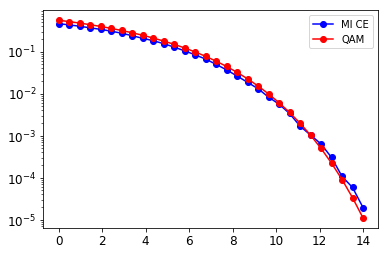

In [17]:
(snr_range,err,qam_err) = noise_perf()
plt.plot(snr_range,err,'bo-',label='MI CE')
plt.plot(snr_range,qam_err,'ro-',label='QAM')
plt.legend()
plt.yscale('log')